In [52]:
import os

print(os.getcwd())

/home/urmzd/Documents/linear-genetic-programming/notebooks


In [53]:
import json
import pathlib
import pandas as pd
import seaborn as sns

from typing import Any, Dict, List

import numpy as np
import matplotlib.pyplot as plt
"""

    Structure:

    generations -> programs (sorted) -> [initial_states] -> [score]

    id: [
        {
            intial_state,
            q_table,
            score
        }
    ]

"""
def get_data_from_logs(log_file_path):
    with open(log_file_path, "r") as f:
        programs: Dict[str, List[Any]] = {}
        line_no = 0
        while line := f.readline():
            line_no += 1
            # print(line_no)
            # we've encountered a new generation
            if "generation" in line:
                # output programs in previous generation
                if len(programs):
                    yield programs
                # reset
                programs = {}
                continue
            else:
                try:
                    program_entry = json.loads(line) 
                except Exception:
                    continue
                id = program_entry["id"] 

                programs.setdefault(id, [])

                programs[id].append(
                    {
                        "score": program_entry["score"],
                        "q_table": program_entry["q_table"]["table"],
                        "initial_state": program_entry["initial_state"] 
                    }
                )

        yield programs
    

path = pathlib.Path(os.getcwd()).parent / "assets/logs/test.log"
assert path.exists()

logs = list(get_data_from_logs(path))

assert len(logs) == 100

"""
What do we want to do here?
   1. Plot the scores of the best, worst and median ranked individuals as a function of their intitial_states
        a. In other words, given an initial state, how long does it take for the individual to accomplish their goal?
        b. We do this to figure out whether or not the intitial state is the reason for the stagnation we see (programs don't score more than ~100 episodes)

    Outstanding question here: is this comparison valid given that Q tables hold state?
        - to be clear, if the q table plays a critical role in the fitness assessement, and each score is derived
        from initial states with different q tables, does it make sense to say that program P performed better with initial state S
        when a previous intial state S' had less info overall? 
        - Should we clone the q_table when testing it with different initial states and set the q_table to the updated table derived during the median score? 
        - Also, should every generation have a new set of intial states?
"""
def convert_logs_to_dataframe(generations):

    bins = np.linspace(-0.4, -0.6)

    score_state_pairs = []

    data = []

    for generation_idx in range(len(generations)):

        # str, [{score, intial_state, q_table}]
        for id, program_entries in generations[generation_idx].items():
            for entry in program_entries:
                data.append({
                    "id": id,
                    "initial_position": entry["initial_state"][0],
                    "score": entry["score"],
                    "generation": generation_idx
                })
    
    return pd.DataFrame.from_records(data)


# df.groupby(["generation"])["fitness"].rank("max")


df = convert_logs_to_dataframe(logs)

# Set fitness.
df["fitness"] = df.groupby(["generation", "id"])["score"].transform("median")

# we need to do a few things.
# group each generation
# group each set of program entries within the generation (subgroup)
# for each subgroup, assigned a rank based relative to other medians within that group

rank_labels = {
    "best": "best",
    "worst": "worst",
    "other": "n/a",
    "median": "median"
}

# TODO: create rankings using fitness
df.query("fitness != -200")

def rank_generation(group):
    ranks = group.groupby("id")["score"].agg("median").rank(method="first")

    max_rank = ranks.max()
    median_rank = ranks.median()

    # label individuals with "best", "worst", "median", or "N/A" based on ranking
    labels = ranks.map(lambda x: rank_labels["worst"] if x == 1 else rank_labels["median"] if x == median_rank else rank_labels["best"] if x == max_rank else rank_labels["other"])

    rank_with_labels = pd.DataFrame({"rank": ranks, "label": labels})

    return rank_with_labels


ranked_labels = df.groupby(["generation"]).apply(rank_generation)

df = df.join(ranked_labels, on=["generation", "id"])
df


,id,initial_position,score,generation,fitness,rank,label
0,83039fa7-2e4f-4dc8-8c99-7a60c342be45,-0.519388,-200.0,0,-200.0,56.0,n/a
1,83039fa7-2e4f-4dc8-8c99-7a60c342be45,-0.468199,-200.0,0,-200.0,56.0,n/a
2,83039fa7-2e4f-4dc8-8c99-7a60c342be45,-0.585789,-200.0,0,-200.0,56.0,n/a
3,83039fa7-2e4f-4dc8-8c99-7a60c342be45,-0.497058,-200.0,0,-200.0,56.0,n/a
4,83039fa7-2e4f-4dc8-8c99-7a60c342be45,-0.563381,-200.0,0,-200.0,56.0,n/a
...,...,...,...,...,...,...,...
49417,368038b2-084c-4d47-bb3b-c41cd599956e,-0.519388,-200.0,99,-200.0,25.0,n/a
49418,368038b2-084c-4d47-bb3b-c41cd599956e,-0.468199,-200.0,99,-200.0,25.0,n/a
49419,368038b2-084c-4d47-bb3b-c41cd599956e,-0.585789,-200.0,99,-200.0,25.0,n/a
49420,368038b2-084c-4d47-bb3b-c41cd599956e,-0.497058,-200.0,99,-200.0,25.0,n/a


                                       id  initial_position  score  \
195  fe978782-2759-4739-bed2-8616020fc516         -0.519388 -200.0   
196  fe978782-2759-4739-bed2-8616020fc516         -0.468199 -200.0   
197  fe978782-2759-4739-bed2-8616020fc516         -0.585789 -200.0   
198  fe978782-2759-4739-bed2-8616020fc516         -0.497058 -200.0   
199  fe978782-2759-4739-bed2-8616020fc516         -0.563381 -200.0   
225  7531ff45-9ff5-4b8b-9d7e-3b19ef913b05         -0.519388 -200.0   
226  7531ff45-9ff5-4b8b-9d7e-3b19ef913b05         -0.468199 -200.0   
227  7531ff45-9ff5-4b8b-9d7e-3b19ef913b05         -0.585789 -200.0   
228  7531ff45-9ff5-4b8b-9d7e-3b19ef913b05         -0.497058 -200.0   
229  7531ff45-9ff5-4b8b-9d7e-3b19ef913b05         -0.563381 -200.0   

     generation  fitness  rank   label  
195           0   -200.0  95.0    best  
196           0   -200.0  95.0    best  
197           0   -200.0  95.0    best  
198           0   -200.0  95.0    best  
199           0   -200.0

<AxesSubplot: xlabel='initial_position', ylabel='score'>

<Figure size 640x480 with 0 Axes>

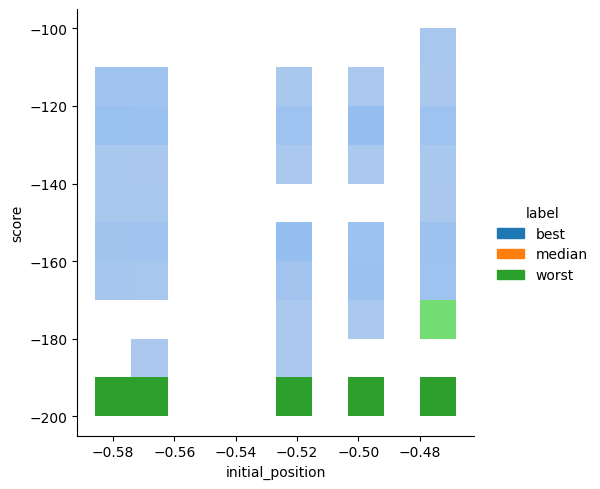

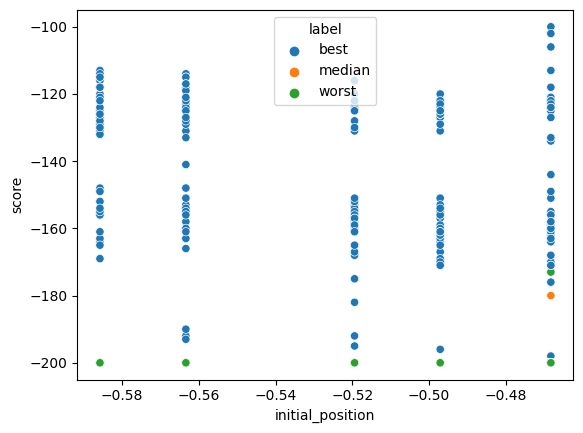

In [57]:
import numpy as np

df2=df[df["generation"] > 0]
df2=df[~(df["label"] == rank_labels["other"])]

print(df2.head(10))

plt.figure()
sns.displot(data=df2, x="initial_position", y="score", hue="label", bins=10)
plt.figure()
sns.scatterplot(data=df2, x="initial_position", y="score", hue="label")